In [2]:
import datetime
import spiceypy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

spiceypy.furnsh("meta_3.txt")

In [3]:
INIT_TIME_UTC = datetime.datetime(year=2000, month=1, day=1, hour=0, minute=0, second=0)

# Add a number of days; you can play around with the datetime variables; but
# leave it as it is for the first try, since other computations and comments
# are based on this value.
DELTA_DAYS = 10000
END_TIME_UTC = INIT_TIME_UTC + datetime.timedelta(days=DELTA_DAYS)

# Convert the datetime objects now to strings
INIT_TIME_UTC_STR = INIT_TIME_UTC.strftime("%Y-%m-%dT%H:%M:%S")
END_TIME_UTC_STR = END_TIME_UTC.strftime("%Y-%m-%dT%H:%M:%S")

# Print the starting and end times
print(f"Init time in UTC: {INIT_TIME_UTC_STR}")
print(f"End time in UTC: {END_TIME_UTC_STR}")

# Convert to Ephemeris Time (ET) using the SPICE function utc2et
INIT_TIME_ET = spiceypy.utc2et(INIT_TIME_UTC_STR)
END_TIME_ET = spiceypy.utc2et(END_TIME_UTC_STR)

# Create a numpy array that covers a time interval in delta = 1 day step
TIME_INTERVAL_ET = np.linspace(INIT_TIME_ET, END_TIME_ET, DELTA_DAYS)

Init time in UTC: 2000-01-01T00:00:00
End time in UTC: 2027-05-19T00:00:00


In [4]:
_, RADII_SUN = spiceypy.bodvcd(bodyid=10, item="RADII", maxn=3)

RADIUS_SUN = RADII_SUN[0]

In [5]:
SOLAR_SYSTEM_DF = pd.DataFrame()

SOLAR_SYSTEM_DF.loc[:, "ET"] = TIME_INTERVAL_ET

SOLAR_SYSTEM_DF.loc[:, "UTC"] = SOLAR_SYSTEM_DF["ET"].apply(
    lambda x: spiceypy.et2datetime(et=x).date()
)

In [6]:
SOLAR_SYSTEM_DF.loc[:, "POS_SSB_WRT_SUN"] = SOLAR_SYSTEM_DF["ET"].apply(
    lambda x: spiceypy.spkgps(targ=0, et=x, ref="ECLIPJ2000", obs=10)[0]
)

SOLAR_SYSTEM_DF.loc[:, "POS_SSB_WRT_SUN_SCALED"] = SOLAR_SYSTEM_DF[
    "POS_SSB_WRT_SUN"
].apply(lambda x: x / RADIUS_SUN)

SOLAR_SYSTEM_DF.loc[:, "SSB_WRT_SUN_SCALED_DIST"] = SOLAR_SYSTEM_DF[
    "POS_SSB_WRT_SUN_SCALED"
].apply(lambda x: spiceypy.vnorm(x))

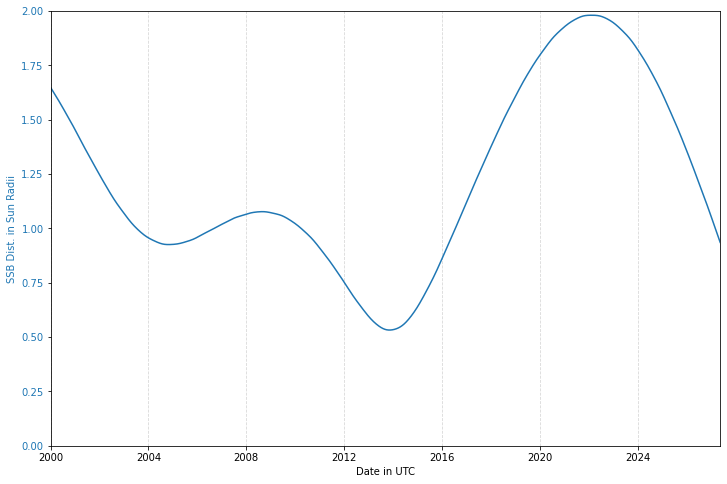

In [7]:
FIG, AX = plt.subplots(figsize=(12, 8))

AX.plot(
    SOLAR_SYSTEM_DF["UTC"], SOLAR_SYSTEM_DF["SSB_WRT_SUN_SCALED_DIST"], color="tab:blue"
)

AX.set_xlabel("Date in UTC")
AX.set_ylabel("SSB Dist. in Sun Radii", color="tab:blue")
AX.tick_params(axis="y", labelcolor="tab:blue")

AX.set_xlim(min(SOLAR_SYSTEM_DF["UTC"]), max(SOLAR_SYSTEM_DF["UTC"]))
AX.set_ylim(0, 2)

AX.grid(axis="x", linestyle="dashed", alpha=0.5)

plt.savefig("SSB2SUN_DISTANCE.png", dpi=300)

In [8]:
NAIF_ID_DICT = {"JUP": 5, "SAT": 6, "URA": 7, "NEP": 8}

for planets_name_key in NAIF_ID_DICT:
    planet_pos_col = f"POS_{planets_name_key}_WRT_SUN"
    planet_angle_col = f"PHASE_ANGLE_SUN_{planets_name_key}2SSB"

    planet_id = NAIF_ID_DICT[planets_name_key]

    SOLAR_SYSTEM_DF.loc[:, planet_pos_col] = SOLAR_SYSTEM_DF["ET"].apply(
        lambda x: spiceypy.spkgps(targ=planet_id, et=x, ref="ECLIPJ2000", obs=10)[0]
    )

    SOLAR_SYSTEM_DF.loc[:, planet_angle_col] = SOLAR_SYSTEM_DF.apply(
        lambda x: np.degrees(spiceypy.vsep(x[planet_pos_col], x["POS_SSB_WRT_SUN"])),
        axis=1,
    )
    
SOLAR_SYSTEM_DF

,ET,UTC,POS_SSB_WRT_SUN,POS_SSB_WRT_SUN_SCALED,SSB_WRT_SUN_SCALED_DIST,POS_JUP_WRT_SUN,PHASE_ANGLE_SUN_JUP2SSB,POS_SAT_WRT_SUN,PHASE_ANGLE_SUN_SAT2SSB,POS_URA_WRT_SUN,PHASE_ANGLE_SUN_URA2SSB,POS_NEP_WRT_SUN,PHASE_ANGLE_SUN_NEP2SSB
0,-4.313582e+04,2000-01-01,"[1068000.1891061615, 417680.9418664607, -30844...","[1.5344830303249446, 0.6001162957851447, -0.04...",1.648254,"[598908596.8744855, 439123369.3393153, -152325...",14.889534,"[958705664.2712355, 982565851.5129774, -552207...",24.342234,"[2158774902.9224224, -2054824933.3744152, -356...",64.937883,"[2514853654.619334, -3738847240.832189, 190394...",77.445335
1,4.327283e+04,2000-01-02,"[1067195.5017360714, 418789.11029741366, -3083...","[1.5333268703104475, 0.6017084918066288, -0.04...",1.647758,"[598225117.4677278, 440087354.7050724, -152212...",14.914467,"[958063473.0643371, 983147892.3545609, -552053...",24.312184,"[2159175581.8195267, -2054425063.723086, -3562...",64.993210,"[2515239547.090654, -3738581393.637231, 190251...",77.505572
2,1.296815e+05,2000-01-03,"[1066389.5596805303, 419896.06924681185, -3081...","[1.5321689075869689, 0.6032989500672584, -0.04...",1.647262,"[597540190.9303206, 441050275.4713855, -152098...",14.939388,"[957420913.2902313, 983729554.4579701, -551899...",24.282130,"[2159576178.598839, -2054025118.301702, -35630...",65.048544,"[2515625411.0398054, -3738315507.093868, 19010...",77.565815
3,2.160901e+05,2000-01-04,"[1065582.365061001, 421001.82313176966, -30802...","[1.5310091452025876, 0.6048876769134621, -0.04...",1.646766,"[596853819.0351244, 442012129.3995018, -151984...",14.964298,"[956777985.169058, 984310837.5777411, -5517446...",24.252071,"[2159976693.248697, -2053625097.1220303, -3563...",65.103885,"[2516011246.46464, -3738049581.200448, 1899644...",77.626064
4,3.024987e+05,2000-01-05,"[1064773.9198190796, 422106.3763607678, -30788...","[1.5298475859469534, 0.6064746786792641, -0.04...",1.646269,"[596166003.5585201, 442972914.2539515, -151870...",14.989197,"[956134688.9209636, 984891741.468534, -5515899...",24.222006,"[2160377125.757261, -2053225000.195851, -35638...",65.159233,"[2516397053.362827, -3737783615.9553304, 18982...",77.686321
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,8.636112e+08,2027-05-14,"[4663.265215005825, 653522.8491930669, -10147....","[0.006700093699721013, 0.938969610909579, -0.0...",0.939107,"[-688383484.555223, 414855236.9208108, 1367843...",59.360113,"[1326956448.3923786, 446110109.44003475, -6059...",70.989152,"[1215409698.341847, 2635431437.281136, -597076...",24.360486,"[4456604657.450317, 312932730.4918787, -109147...",85.554647
9996,8.636976e+08,2027-05-15,"[3986.9114982562483, 652910.4356407273, -10131...","[0.005728321118184265, 0.9380897063803553, -0....",0.938220,"[-688979164.3741282, 413939694.96913993, 13695...",59.378969,"[1326644315.3040218, 446898893.90563047, -6059...",71.013447,"[1214870329.4222531, 2635649827.5410657, -5962...",24.407941,"[4456568044.100192, 313403407.7570772, -109156...",85.607550
9997,8.637841e+08,2027-05-16,"[3311.597377454852, 652297.295702135, -10115.7...","[0.004758042208986856, 0.9372087581927226, -0....",0.937334,"[-689573528.8899947, 413023362.7284355, 137126...",59.397796,"[1326331705.1926196, 447687516.6841836, -60593...",71.037759,"[1214330912.2278621, 2635868110.086686, -59551...",24.455415,"[4456531382.243483, 313874080.81980485, -10916...",85.660473
9998,8.638705e+08,2027-05-17,"[2637.3234622905757, 651683.4323080052, -10099...","[0.0037892578481186433, 0.9363267705574787, -0...",0.936447,"[-690166577.1579771, 412106242.06303275, 13729...",59.416597,"[1326018618.1262968, 448475977.4791429, -60594...",71.062089,"[1213791446.779824, 2636086284.9090424, -59473...",24.502909,"[4456494671.881106, 314344749.6777499, -109174...",85.713416


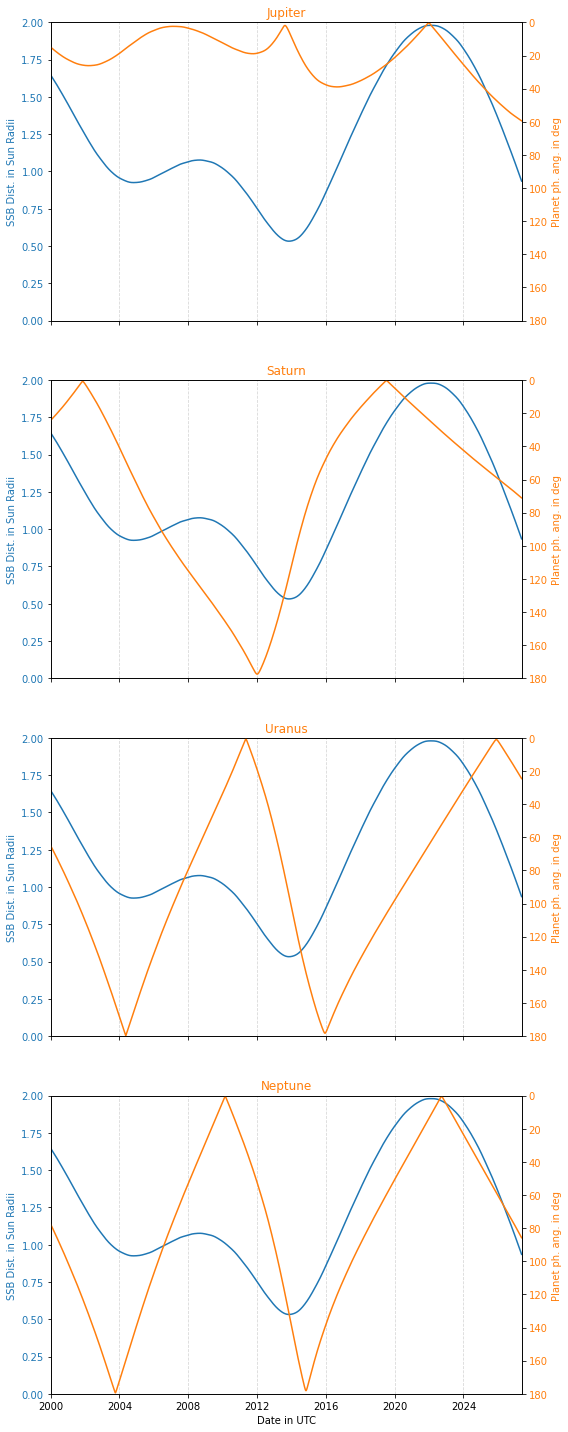

In [9]:
FIG, (AX1, AX2, AX3, AX4) = plt.subplots(4, 1, sharex=True, figsize=(8, 20))

for ax_f, planet_abr, planet_name in zip(
    [AX1, AX2, AX3, AX4],
    ["JUP", "SAT", "URA", "NEP"],
    ["Jupiter", "Saturn", "Uranus", "Neptune"],
):
    ax_f.set_title(planet_name, color="tab:orange")

    ax_f.plot(
        SOLAR_SYSTEM_DF["UTC"],
        SOLAR_SYSTEM_DF["SSB_WRT_SUN_SCALED_DIST"],
        color="tab:blue",
    )

    ax_f.set_ylabel("SSB Dist. in Sun Radii", color="tab:blue")
    ax_f.tick_params(axis="y", labelcolor="tab:blue")

    ax_f.set_xlim(min(SOLAR_SYSTEM_DF["UTC"]), max(SOLAR_SYSTEM_DF["UTC"]))
    ax_f.set_ylim(0, 2)

    ax_f_add = ax_f.twinx()

    ax_f_add.plot(
        SOLAR_SYSTEM_DF["UTC"],
        SOLAR_SYSTEM_DF[f"PHASE_ANGLE_SUN_{planet_abr}2SSB"],
        color="tab:orange",
        linestyle="-",
    )

    ax_f_add.set_ylabel("Planet ph. ang. in deg", color="tab:orange")
    ax_f_add.tick_params(axis="y", labelcolor="tab:orange")

    ax_f_add.invert_yaxis()
    ax_f_add.set_ylim(180, 0)

    ax_f.grid(axis="x", linestyle="dashed", alpha=0.5)


AX4.set_xlabel("Date in UTC")
FIG.tight_layout()
plt.subplots_adjust(hspace=0.2)

plt.savefig("PLANETS_SUN_SSB_PHASE_ANGLE.png", dpi=300)